## Jobs and commutes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\Users\marno\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
INSEE_jobs = 'C:/Users/marno/Documents/Python Projects/paris-roadspace/data/jobs/'

### Load & filter data

Keep only fluxes of workers to or from Paris or first ring

In [3]:
# Load
jobs = pd.read_csv(INSEE_jobs+'base-flux-mobilite-domicile-lieu-travail-2020.csv', 
                   sep=';', dtype={'CODGEO': np.string_,
                                   'LIBGEO': np.string_, 
                                   'DCLT': np.string_,
                                   'L_DCLT':np.string_,
                                   'NBFLUX_C20_ACTOCC15P':np.float64})
jobs.columns = ['CODGEO', 'LIBGEO', 'DCLT', 'L_DCLT', 'Flux']

# Determine what to keep
keep_deps = ['75', '92', '93', '94'] # departments to keep, first is paris, latter three are first ring
all_geos = set(list(jobs.CODGEO.unique()) + list(jobs.DCLT.unique()))
keep = set(geo for geo in all_geos if str(geo)[:2] in keep_deps) # first two figures in geocode correspond to department
i_keep = pd.concat([jobs.loc[jobs.CODGEO.isin(keep)], jobs.loc[jobs.DCLT.isin(keep)]]).index.drop_duplicates()

# Drop the rest
i_drop = jobs.index.difference(i_keep)
before = len(jobs)
jobs.drop(index=i_drop, inplace=True)
print(f'Dropped {before-len(jobs)} of {before} rows, {len(jobs)} remaining')

Dropped 864074 of 977682 rows, 113608 remaining


Done

### Label, group, and sum fluxes

Simplify fluxes between city, ring, and external

In [4]:
# Create columns for storing labels
jobs['home'] = 0
jobs['job'] = 0

# Translate department numbers to label
label_dict = {'75': 'City',
            '92': 'Ring',
            '93': 'Ring',
            '94': 'Ring'}

# Apply labels, 'External' if one side of the commute is not in either City or Ring
for i, row in jobs.iterrows():
    # Label City and Ring
    for geo, label_col in zip([row.CODGEO, row.DCLT], ['home', 'job']):
        dep = geo[:2]
        if dep in keep_deps:
            jobs.at[i, label_col] = label_dict[dep]
        else:
            jobs.at[i, label_col] = 'External' 

C:\Users\marno\AppData\Local\Temp\ipykernel_24000\3462694751.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'External' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jobs.at[i, label_col] = 'External'
C:\Users\marno\AppData\Local\Temp\ipykernel_24000\3462694751.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Ring' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jobs.at[i, label_col] = label_dict[dep]


In [5]:
# Create column for liaison, which to group and sum the data by
jobs['relation'] =  jobs[['home', 'job']].agg(' to '.join, axis=1)

In [6]:
by_relation = jobs.groupby(by='relation').sum(numeric_only=True)
by_relation.to_excel(INSEE_jobs+'grouped_by_relation.xlsx')

Flux d'actifs de 15 ans ou plus ayant un emploi

In [7]:
by_job_location = jobs.groupby(by='job').sum(numeric_only=True)
by_job_location

,Flux
job,
City,1.861790e+06
External,2.945672e+05
Ring,2.094629e+06


In [8]:
by_home_location = jobs.groupby(by='home').sum(numeric_only=True)
by_home_location

,Flux
home,
City,1.072912e+06
External,1.109924e+06
Ring,2.068150e+06


<Axes: title={'center': 'By Home Location'}, xlabel='Home Location', ylabel='Commuters'>

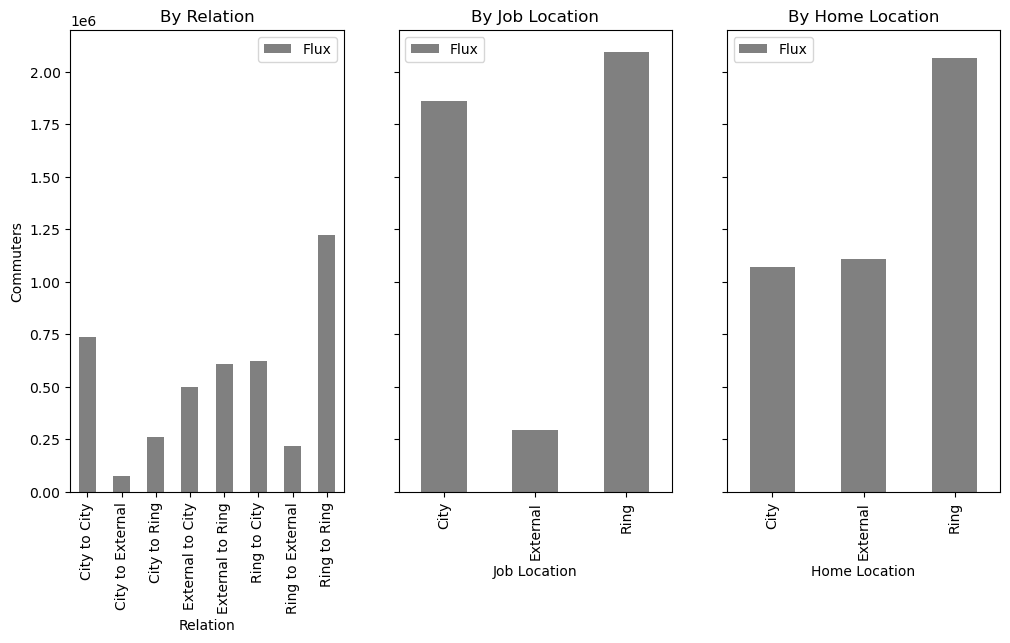

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,6), sharey=True)
by_relation.plot(kind='bar', title='By Relation', ylabel='Commuters', xlabel='Relation', color='grey', ax=ax[0])
by_job_location.plot(kind='bar', title='By Job Location', ylabel='Commuters', xlabel='Job Location', color='grey', ax=ax[1])
by_home_location.plot(kind='bar', title='By Home Location', ylabel='Commuters', xlabel='Home Location', color='grey', ax=ax[2])

<Axes: title={'center': 'By Relation'}, xlabel='Relation', ylabel='Commuters'>

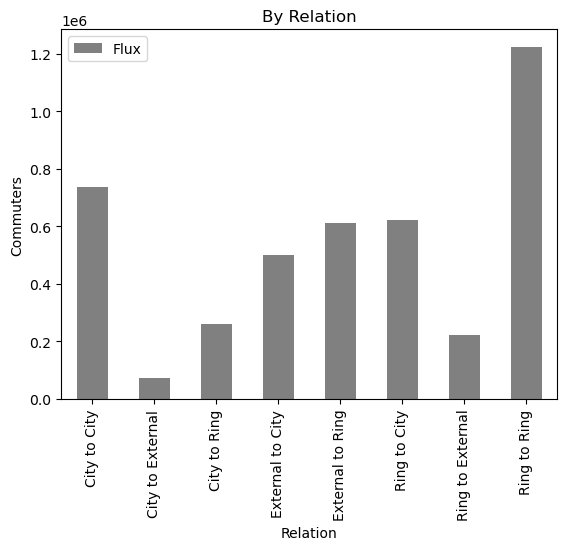

In [10]:
by_relation.plot(kind='bar', title='By Relation', ylabel='Commuters', xlabel='Relation', color='grey')